# Simulated bandwidth limited thermal noise + sine wave fun

If we take a measurement of the gain of a system can we generate some bandwidth limited thermal noise and compare this to measured signals.



In [1]:
from PyScopeTools import PyScopeTools as pst
from PyFFTTools import PyFFTTools as pft
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.signal import savgol_filter
import matplotlib.style
import matplotlib as mpl
import math
import scipy.fftpack
from scipy.signal import butter,filtfilt
from scipy.fft import fft, ifft  # Import the fft and inverse fft functions

# Import the curve_fit function
from scipy.optimize import curve_fit

#Set default figure size
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams.update({'font.size': 22})

In [2]:
arrNoise = np.loadtxt("caldata/LMNOCOUPLERFNOISE.CSV",delimiter=",", dtype=float,skiprows=3)
arrSine = np.loadtxt("caldata/LMNOCOUPLERSINE.CSV",delimiter=",", dtype=float,skiprows=3)

In [3]:
#Now we can get some frequency bins, which we will get by defining some time sampling
N=100000
dt=(1/20e9) #20GSa/s
fs=1/dt
#dt=(1/10e9) #20GSa/s
t=np.linspace(0,dt*(N-1),N)
xf = pft.getFrequencyBins(N,dt)
print("t.shape",t.shape)
print("xf.shape",xf.shape)

t.shape (100000,)
xf.shape (50001,)


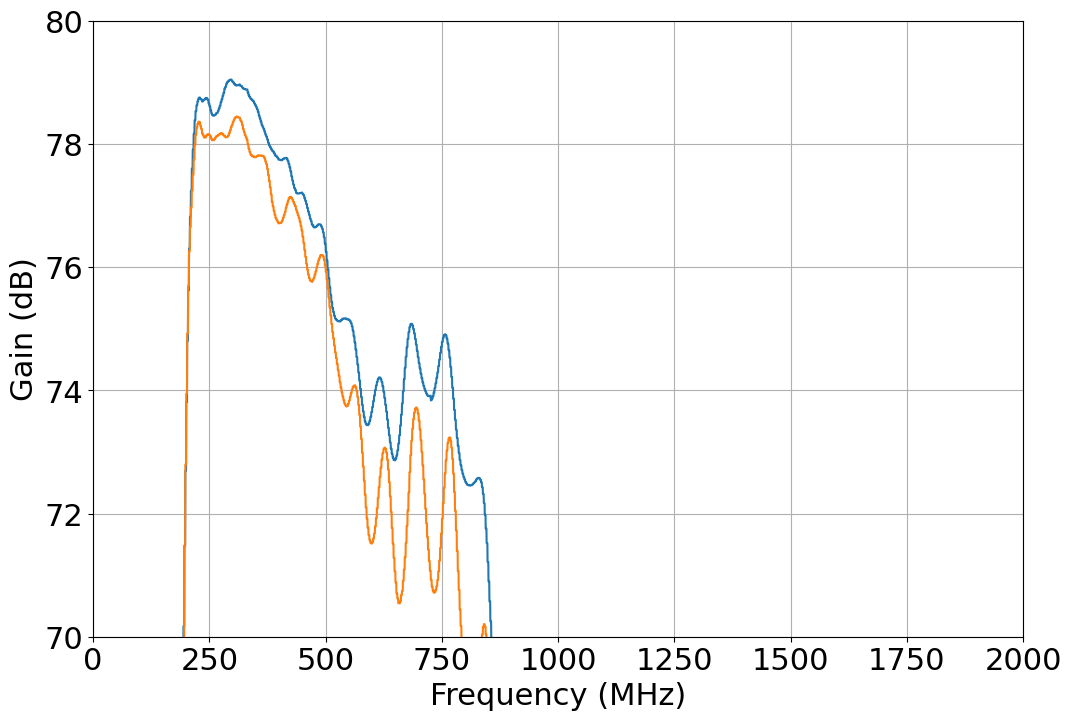

In [4]:
gainNoise=pft.convertFrequencyBinning(arrNoise,xf) +63 #For 60dB of attenuation in VNA measurement + 3dB since both halfs of spliter contribute
gainSine=pft.convertFrequencyBinning(arrSine,xf) +63 #For 60dB of attenuation in VNA measurement + 3dB since both halfs of spliter contribute

fig, ax = plt.subplots()
ax.plot(xf/1e6,gainNoise)
ax.plot(xf/1e6,gainSine)
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Gain (dB)")
ax.set_xlim([0,2000])
ax.set_ylim([70,80])
ax.grid()

In [5]:
from scipy.fft import rfft, irfft  # Import the fft and inverse fft functions


## Now lets add some signal!!

So here we have defined our prescription for generating noise. Our next steps are to add a sine wave and see how well we can extract it from the noise.

In [6]:
def getSine(t,w,A,phi):
    """Function to return a simple sine 

    Args:
        t: The array of times
        w: The angular frequency
        A: The amplitude
        phi: The phase at t=0
 
     Returns:
        The sine values as an array

    """
    return A*np.sin((w*t)+phi)

def generateNoise(t,gainNoise):
    xf = pft.getFrequencyBins(len(t),t[1]-t[0])
    rfftVals=pft.generateThermalNoiseRFFT(xf,gainNoise,T=292,R=50)
    noiseVals=irfft(rfftVals)
    return noiseVals
    
    
    
def generateNoiseAndFit(tSine,vSine,gainNoise,numWaveforms,thisFreq,thisAmp):
    xf = pft.getFrequencyBins(len(tSine),tSine[1]-tSine[0])
    guessPhase=0
    guessOmega=thisFreq*2*math.pi
    guessAmp=thisAmp
    
    omegas=np.zeros(numWaveforms)
    freqs=np.zeros(numWaveforms)
    amps=np.zeros(numWaveforms)
    phases=np.zeros(numWaveforms)
    failCount=0

    print(xf.shape,gainNoise.shape,tSine.shape)
    
    for i in range(numWaveforms):
        rfftVals=pft.generateThermalNoiseRFFT(xf,gainNoise,T=292,R=50)
        noiseVals=irfft(rfftVals)
        try:
            parameters, covariance = curve_fit(getSine, tSine, vSine+noiseVals,p0=[guessOmega,guessAmp,guessPhase])
        except:
            print("Failure ",failCount," to fit",i)
            failCount=failCount+1
            if(failCount>10):
                raise Exception("Sorry I've given up after failing to fit",failCount)
        omegas[i]=parameters[0]
        freqs[i]=parameters[0]/(2*math.pi)
        amps[i]=parameters[1]
        phases[i]=parameters[2]
    return omegas,freqs,amps,phases

In [7]:
thisFreq=300e6
thisAmp=0.1

/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_2971/1026499346.py:16: RuntimeWarning: divide by zero encountered in divide
  return 1./(1+np.power(fc/xf,2*order))
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_2971/1026499346.py:23: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(gain)
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_2971/1026499346.py:16: RuntimeWarning: overflow encountered in power
  return 1./(1+np.power(fc/xf,2*order))


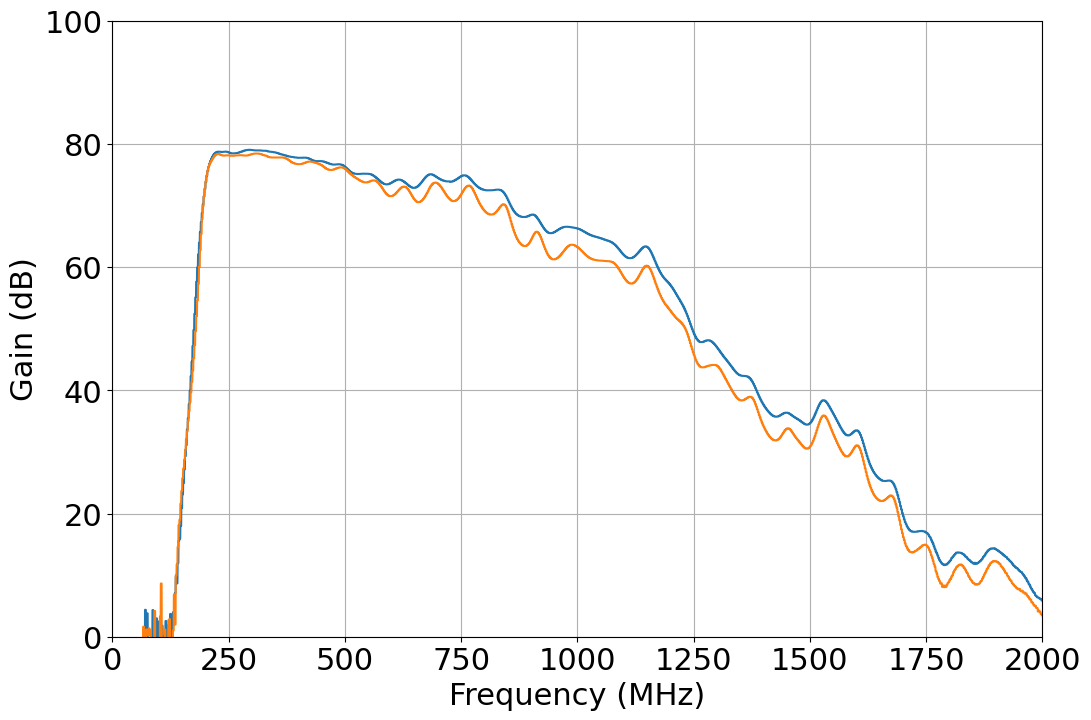

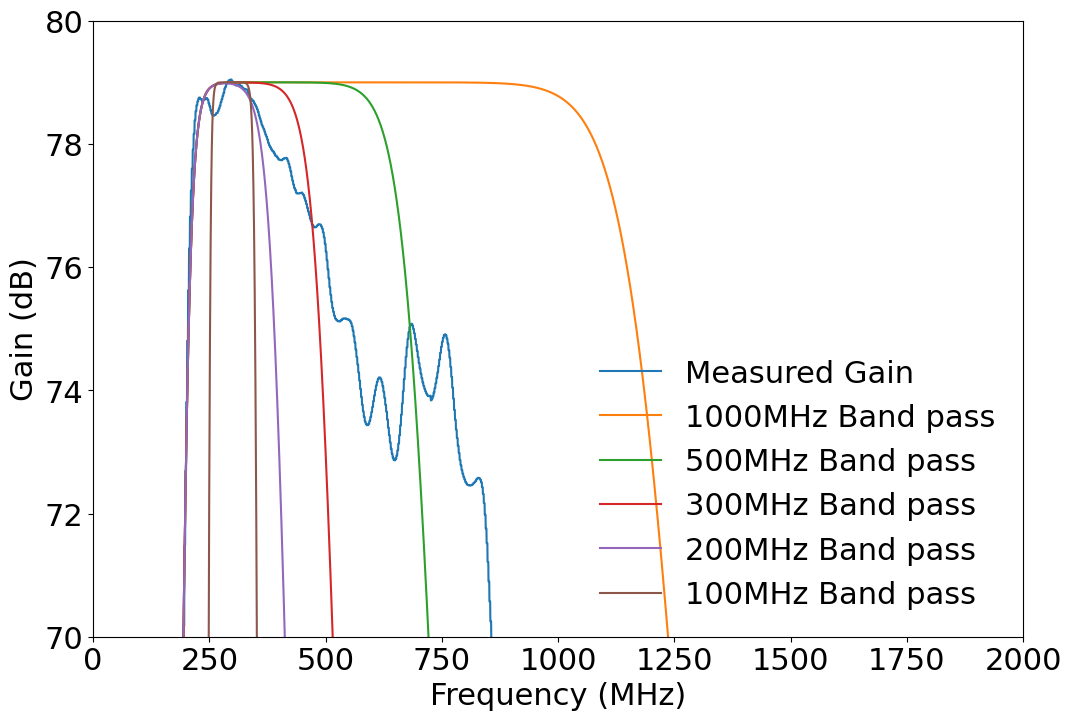

In [8]:

fig, ax = plt.subplots()
ax.plot(xf/1e6,gainNoise)
ax.plot(xf/1e6,gainSine)
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Gain (dB)")
ax.set_xlim([0,2000])
ax.set_ylim([0,100])
ax.grid()


def butterworthLowPass(xf,fc,order):
    return 1./(1+np.power(xf/fc,2*order))


def butterworthHighPass(xf,fc,order):
    return 1./(1+np.power(fc/xf,2*order))


def butterworthBandPass(xf,low,high,order,gain=1):
    return gain*butterworthHighPass(xf,low,order)*butterworthLowPass(xf,high,order)

def connvertGainTodB(gain):
    return 20*np.log10(gain)


def connvertdBToGain(dB):
    return np.power(10,dB/20)

fig, ax = plt.subplots()
#ax.plot(xf/1e6,butterworthLowPass(xf,500e6,9))
#ax.plot(xf/1e6,butterworthHighPass(xf,500e6,9))
ax.plot(xf/1e6,gainNoise,label="Measured Gain")
ax.plot(xf/1e6,connvertGainTodB(butterworthBandPass(xf,200e6,1200e6,10,connvertdBToGain(79))),label="1000MHz Band pass")
ax.plot(xf/1e6,connvertGainTodB(butterworthBandPass(xf,200e6,700e6,10,connvertdBToGain(79))),label="500MHz Band pass")
ax.plot(xf/1e6,connvertGainTodB(butterworthBandPass(xf,200e6,500e6,10,connvertdBToGain(79))),label="300MHz Band pass")
ax.plot(xf/1e6,connvertGainTodB(butterworthBandPass(xf,200e6,400e6,10,connvertdBToGain(79))),label="200MHz Band pass")
ax.plot(xf/1e6,connvertGainTodB(butterworthBandPass(xf,250e6,350e6,50,connvertdBToGain(79))),label="100MHz Band pass")

ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Gain (dB)")
ax.set_xlim([0,2000])
ax.set_ylim([70,80])
ax.legend()



In [9]:
ampList = np.linspace(0.1,1,10)
scaledAmpList=ampList*np.power(10,-79/20)
print(scaledAmpList)
print(ampList/scaledAmpList)


def trimAndDownsample(array,start,stop,step):
    if array.ndim==2:
        return array[:,start:stop:step]
    else:
        return array[start:stop:step]

def find_nearest_index(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def doSingleLoopForNetwork(gainNetwork,ampList,thisFreq,numWaves=1000):
    #Now some hideous code because I'm too lazy too chaneg the amplitude of the sine wave properly
    xf = pft.getFrequencyBins(len(t),t[1]-t[0])
    idx= find_nearest_index(xf,thisFreq)
    thisGaindB=gainNetwork[idx]
    voltScale=np.power(10,thisGaindB/20)
    
    netFitAmpMeanList=[]
    netFitAmpStdList=[]
    netFitFreqMeanList=[]
    netFitFreqStdList=[]
    for rawAmp in ampList:
        thisAmp=rawAmp*voltScale
        print("Starting",thisFreq,thisAmp,thisAmp)
        grSine=getSine(t,thisFreq*2*math.pi,thisAmp,0)
        netOmega,netFreq,netAmp,netPhase=generateNoiseAndFit(t,grSine,gainNetwork,numWaves,thisFreq,thisAmp)
        netFitFreqStdList.append(np.std(netFreq))
        netFitFreqMeanList.append(np.mean(netFreq))
        netFitAmpMeanList.append(np.mean(netAmp))
        netFitAmpStdList.append(np.std(netAmp))
    return netFitAmpMeanList,netFitAmpStdList,netFitFreqMeanList,netFitFreqStdList

def getGainCurveDifferentTime(xf,gainNetwork,newTime):
    newxf = pft.getFrequencyBins(len(newTime),newTime[1]-newTime[0])
    df=xf[1]-xf[0]
    newdf=newxf[1]-newxf[0]
#    print("gGC",np.shape(xf),xf[0],xf[1],xf[2],xf[-1])
#    print("gGCNew",np.shape(newxf),newxf[0],newxf[1],newxf[2],newxf[-1])
#    print("getGainCurve",np.shape(newTime),np.shape(newxf),len(newTime),newTime[1]-newTime[0])
#    print("getGainCurveDifferentTime",df,newdf,newdf/df)
    ind=np.arange(newxf.shape[0])
    ind=np.array(ind*newdf/df).astype(int)
    return gainNetwork[ind]
    
def generateNoiseAndTrimAndFit(tOrig,tSine,vSine,gainNoise,numWaveforms,thisFreq,thisAmp,start,stop,step):
    xf = pft.getFrequencyBins(len(tOrig),tOrig[1]-tOrig[0])
    guessPhase=0
    guessOmega=thisFreq*2*math.pi
    guessAmp=thisAmp
    omegas=np.zeros(numWaveforms)
    freqs=np.zeros(numWaveforms)
    amps=np.zeros(numWaveforms)
    phases=np.zeros(numWaveforms)
    failCount=0

    for i in range(numWaveforms):
        rfftVals=pft.generateThermalNoiseRFFT(xf,gainNoise,T=292,R=50)
        noiseVals=irfft(rfftVals)
        vNew=trimAndDownsample(vSine+noiseVals,start,stop,step)
        try:
            parameters, covariance = curve_fit(getSine, tSine, vNew,p0=[guessOmega,guessAmp,guessPhase])
        except:
            print("Failure ",failCount," to fit",i)
            failCount=failCount+1
            if(failCount>10):
                raise Exception("Sorry I've given up after failing to fit",failCount)
        omegas[i]=parameters[0]
        freqs[i]=parameters[0]/(2*math.pi)
        amps[i]=parameters[1]
        phases[i]=parameters[2]
    return omegas,freqs,amps,phases

def doSingleLoopForNetworkSamplingRate(gainNetwork,rawAmp,thisFreq,stepArray,numWaves=2000):
    #Now some hideous code because I'm too lazy too chaneg the amplitude of the sine wave properly
    startXf = pft.getFrequencyBins(len(t),t[1]-t[0])
    idx= find_nearest_index(startXf,thisFreq)
    thisGaindB=gainNetwork[idx]
    voltScale=np.power(10,thisGaindB/20)
    netFitAmpMeanList=[]
    netFitAmpStdList=[]
    netFitFreqMeanList=[]
    netFitFreqStdList=[]
    msaPerSecArray=np.zeros(stepArray.shape)
    thisAmp=rawAmp*voltScale
    for ind,step in enumerate(stepArray):
        print("Starting",thisFreq,thisAmp,step)
                #Now we are going to reshape our array to have fewer entries
        start=0 #Start index
        stop=100000 #Stop index
        ntList=trimAndDownsample(t,start,stop,step)
        N=ntList.shape[0] #
        dt=ntList[1]-ntList[0]
        fs=1./dt
        msaPerSecArray[ind]=fs
        grSine=getSine(t,thisFreq*2*math.pi,thisAmp,0)
        netOmega,netFreq,netAmp,netPhase=generateNoiseAndTrimAndFit(t,ntList,grSine,gainNetwork,numWaves,thisFreq,thisAmp,start,stop,step)
        netFitFreqStdList.append(np.std(netFreq))
        netFitFreqMeanList.append(np.mean(netFreq))
        netFitAmpMeanList.append(np.mean(netAmp))
        netFitAmpStdList.append(np.std(netAmp))
    return netFitAmpMeanList,netFitAmpStdList,netFitFreqMeanList,netFitFreqStdList,msaPerSecArray




[1.12201845e-05 2.24403691e-05 3.36605536e-05 4.48807382e-05
 5.61009227e-05 6.73211073e-05 7.85412918e-05 8.97614763e-05
 1.00981661e-04 1.12201845e-04]
[8912.50938134 8912.50938134 8912.50938134 8912.50938134 8912.50938134
 8912.50938134 8912.50938134 8912.50938134 8912.50938134 8912.50938134]


In [10]:

stepArray=np.array([1,10,15,20,25,30,35])
gainBandPass200=connvertGainTodB(butterworthBandPass(xf,200e6,400e6,10,connvertdBToGain(79)))
bp200AmpMean,bp200AmpStd,bp200FreqMean,bp200FreqStd,msaPerSecArray=doSingleLoopForNetworkSamplingRate(gainBandPass200,scaledAmpList[4],300e6,stepArray)
bpFullAmpMean,bpFullAmpStd,bpFullFreqMean,bpFullFreqStd,msaPerSecArray=doSingleLoopForNetworkSamplingRate(gainNoise,scaledAmpList[4],300e6,stepArray)




#gainBandPass20=connvertGainTodB(butterworthBandPass(xf,290e6,310e6,100,connvertdBToGain(79)))
#bp20AmpMean,bp20AmpStd,bp20FreqMean,bp20FreqStd=doSingleLoopForNetwork(gainBandPass20,scaledAmpList,300e6)
#gainBandPass300=connvertGainTodB(butterworthBandPass(xf,200e6,500e6,10,connvertdBToGain(79)))
#bp300AmpMean,bp300AmpStd,bp300FreqMean,bp300FreqStd=doSingleLoopForNetwork(gainBandPass300,scaledAmpList,300e6)
#gainBandPass500=connvertGainTodB(butterworthBandPass(xf,200e6,200e6+500e6,10,connvertdBToGain(79)))
#bp500AmpMean,bp500AmpStd,bp500FreqMean,bp500FreqStd=doSingleLoopForNetwork(gainBandPass500,scaledAmpList,300e6)
#gainBandPass1000=connvertGainTodB(butterworthBandPass(xf,200e6,200e6+1000e6,10,connvertdBToGain(79)))
#bp1000AmpMean,bp1000AmpStd,bp1000FreqMean,bp1000FreqStd=doSingleLoopForNetwork(gainBandPass1000,scaledAmpList,300e6)

Starting 300000000.0 0.4982695624899826 1


/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_2971/1026499346.py:16: RuntimeWarning: divide by zero encountered in divide
  return 1./(1+np.power(fc/xf,2*order))
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_2971/1026499346.py:23: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(gain)


Starting 300000000.0 0.4982695624899826 10
Starting 300000000.0 0.4982695624899826 15
Starting 300000000.0 0.4982695624899826 20
Starting 300000000.0 0.4982695624899826 25
Starting 300000000.0 0.4982695624899826 30
Starting 300000000.0 0.4982695624899826 35
Starting 300000000.0 0.5004535110024338 1
Starting 300000000.0 0.5004535110024338 10
Starting 300000000.0 0.5004535110024338 15
Starting 300000000.0 0.5004535110024338 20
Starting 300000000.0 0.5004535110024338 25
Starting 300000000.0 0.5004535110024338 30
Starting 300000000.0 0.5004535110024338 35


In [11]:
gainBandPass300=connvertGainTodB(butterworthBandPass(xf,200e6,500e6,10,connvertdBToGain(79)))
bp300AmpMean,bp300AmpStd,bp300FreqMean,bp300FreqStd,msaPerSecArray=doSingleLoopForNetworkSamplingRate(gainBandPass300,scaledAmpList[4],300e6,stepArray)

/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_2971/1026499346.py:16: RuntimeWarning: divide by zero encountered in divide
  return 1./(1+np.power(fc/xf,2*order))
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_2971/1026499346.py:23: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(gain)


Starting 300000000.0 0.49983140624721173 1
Starting 300000000.0 0.49983140624721173 10
Starting 300000000.0 0.49983140624721173 15
Starting 300000000.0 0.49983140624721173 20
Starting 300000000.0 0.49983140624721173 25
Starting 300000000.0 0.49983140624721173 30
Starting 300000000.0 0.49983140624721173 35


In [12]:
gainBandPass100=connvertGainTodB(butterworthBandPass(xf,250e6,350e6,50,connvertdBToGain(79)))
bp100AmpMean,bp100AmpStd,bp100FreqMean,bp100FreqStd,msaPerSecArray=doSingleLoopForNetworkSamplingRate(gainBandPass100,scaledAmpList[4],300e6,stepArray)

/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_2971/1026499346.py:16: RuntimeWarning: divide by zero encountered in divide
  return 1./(1+np.power(fc/xf,2*order))
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_2971/1026499346.py:16: RuntimeWarning: overflow encountered in power
  return 1./(1+np.power(fc/xf,2*order))
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_2971/1026499346.py:23: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(gain)


Starting 300000000.0 0.49999989296973874 1
Starting 300000000.0 0.49999989296973874 10
Starting 300000000.0 0.49999989296973874 15
Starting 300000000.0 0.49999989296973874 20
Starting 300000000.0 0.49999989296973874 25
Starting 300000000.0 0.49999989296973874 30
Starting 300000000.0 0.49999989296973874 35


Text(0.5, 1.0, 'Observation Time 5.0e-06s')

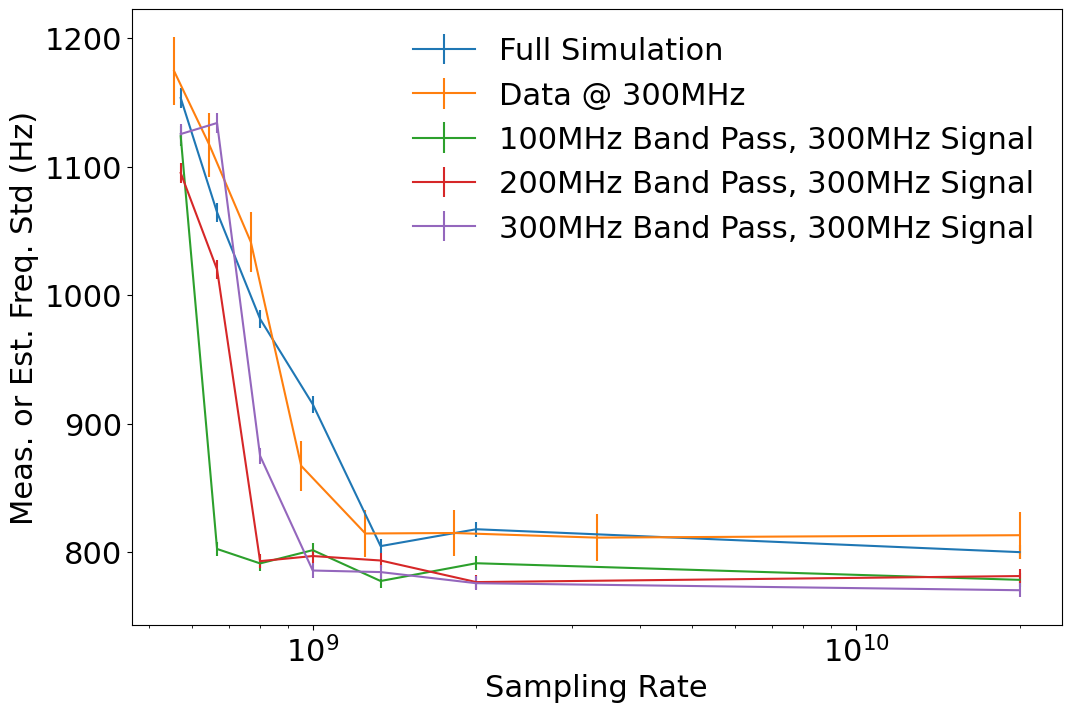

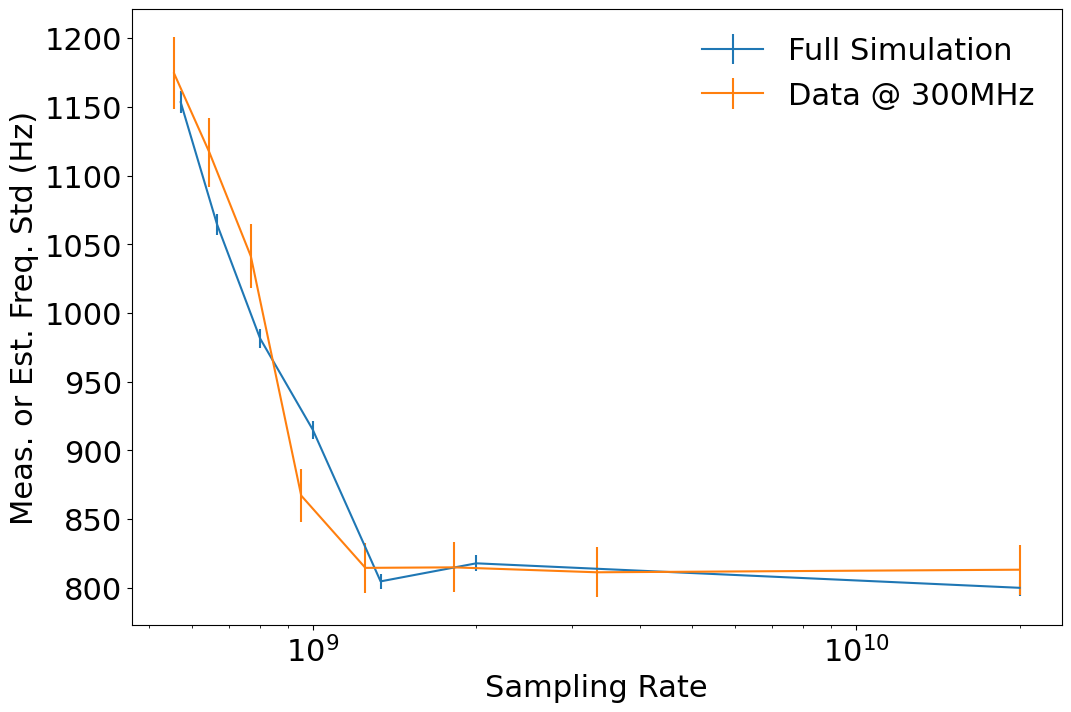

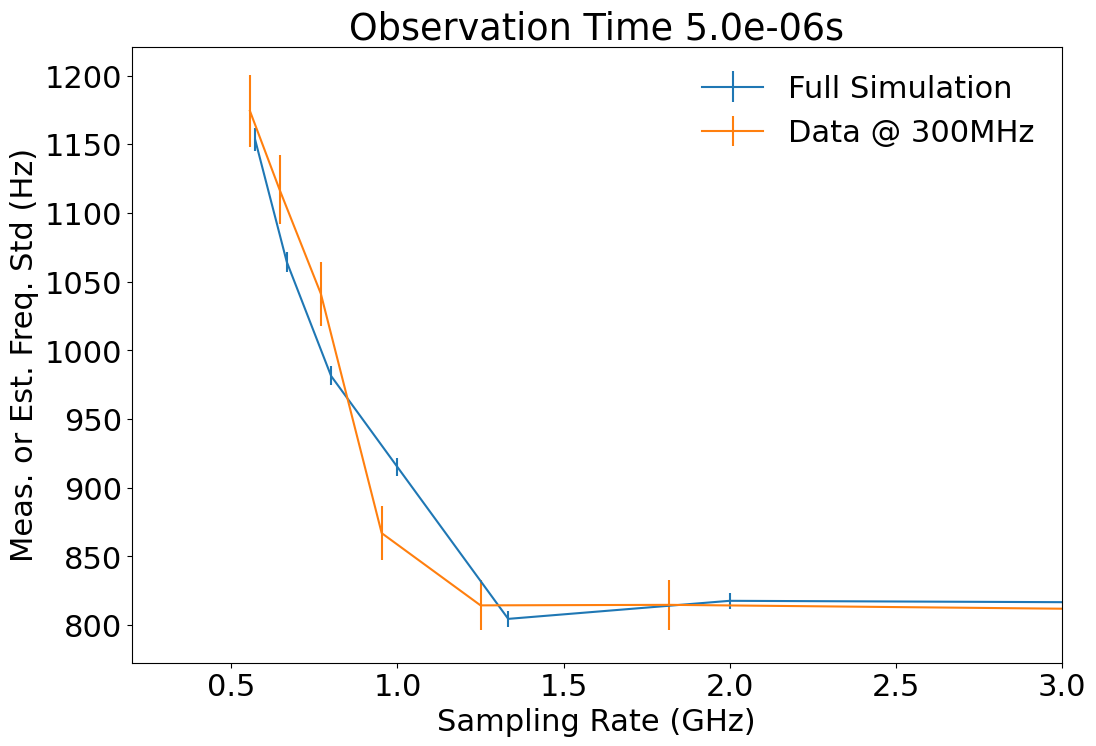

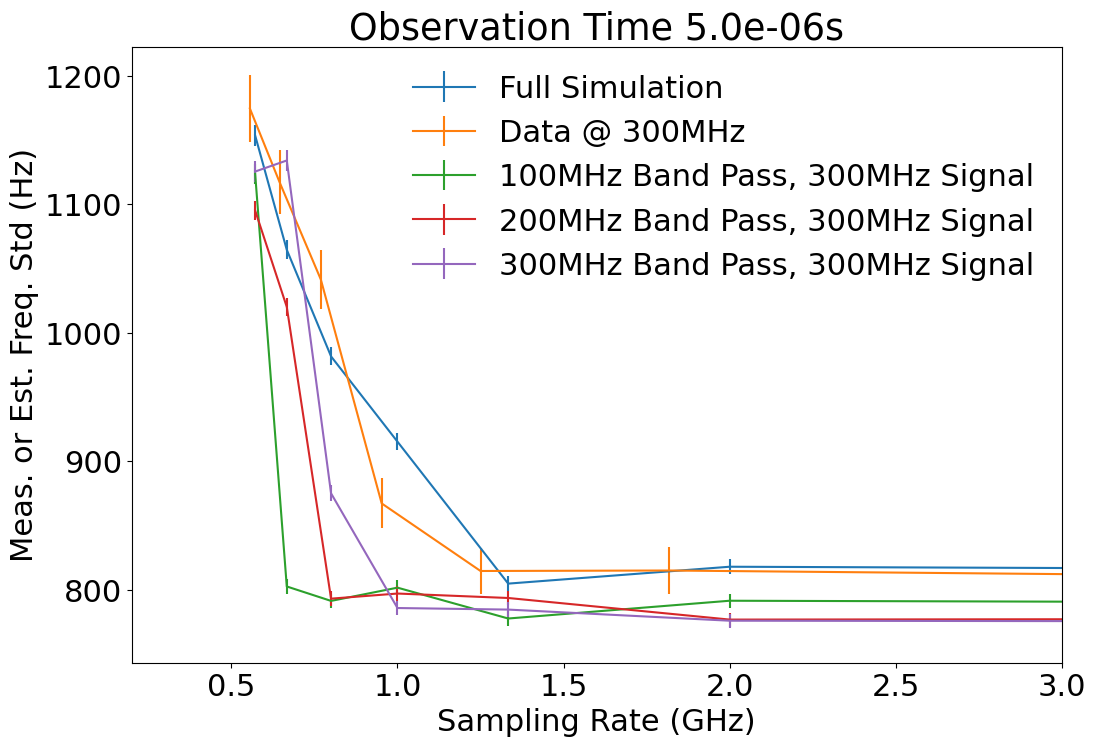

In [13]:
fig,ax = plt.subplots()
ax.errorbar(msaPerSecArray,bpFullFreqStd,yerr=bpFullFreqStd/np.sqrt(2*(10000-1)),label="Full Simulation")

measSps=np.array([19999.99973288,  3333.33328881,  1818.1817939,   1249.99998331, 952.38093966,   769.23075896,   645.16128171,   555.55554814])*1e6
measStd10000=np.array([0.02539105, 0.02542939, 0.02552737, 0.02547196, 0.02741887, 0.03304477, 0.03514254, 0.0354771 ])*1e6
measStd100000=np.array([0.00081308, 0.00081119, 0.00081479, 0.00081441, 0.00086702, 0.00104129, 0.00111695, 0.00117444])*1e6
ax.errorbar(measSps,measStd100000,yerr=measStd100000/np.sqrt(2*(1000-1)),label="Data @ 300MHz")
ax.errorbar(msaPerSecArray,bp100FreqStd,yerr=bp100FreqStd/np.sqrt(2*(10000-1)),label="100MHz Band Pass, 300MHz Signal")
ax.errorbar(msaPerSecArray,bp200FreqStd,yerr=bp200FreqStd/np.sqrt(2*(10000-1)),label="200MHz Band Pass, 300MHz Signal")
ax.errorbar(msaPerSecArray,bp300FreqStd,yerr=bp300FreqStd/np.sqrt(2*(10000-1)),label="300MHz Band Pass, 300MHz Signal")
ax.set_xlabel("Sampling Rate")
ax.set_ylabel("Meas. or Est. Freq. Std (Hz)")
ax.legend()
#ax.set_yscale('log')
ax.set_xscale('log')


fig,ax = plt.subplots()
ax.errorbar(msaPerSecArray,bpFullFreqStd,yerr=bpFullFreqStd/np.sqrt(2*(10000-1)),label="Full Simulation")
measSps=np.array([19999.99973288,  3333.33328881,  1818.1817939,   1249.99998331, 952.38093966,   769.23075896,   645.16128171,   555.55554814])*1e6
measStd10000=np.array([0.02539105, 0.02542939, 0.02552737, 0.02547196, 0.02741887, 0.03304477, 0.03514254, 0.0354771 ])*1e6
measStd100000=np.array([0.00081308, 0.00081119, 0.00081479, 0.00081441, 0.00086702, 0.00104129, 0.00111695, 0.00117444])*1e6
ax.errorbar(measSps,measStd100000,yerr=measStd100000/np.sqrt(2*(1000-1)),label="Data @ 300MHz")
#ax.errorbar(msaPerSecArray,bp100FreqStd,yerr=bp100FreqStd/np.sqrt(2*(10000-1)),label="100MHz Band Pass, 300MHz Signal")
#ax.errorbar(msaPerSecArray,bp200FreqStd,yerr=bp200FreqStd/np.sqrt(2*(10000-1)),label="200MHz Band Pass, 300MHz Signal")
#ax.errorbar(msaPerSecArray,bp300FreqStd,yerr=bp300FreqStd/np.sqrt(2*(10000-1)),label="300MHz Band Pass, 300MHz Signal")
ax.set_xlabel("Sampling Rate")
ax.set_ylabel("Meas. or Est. Freq. Std (Hz)")
ax.legend()
#ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_title('Observation Time {:.1e}s'.format(bigT))


fig,ax = plt.subplots()
ax.errorbar(msaPerSecArray/1e9,bpFullFreqStd,yerr=bpFullFreqStd/np.sqrt(2*(10000-1)),label="Full Simulation")
measSps=np.array([19999.99973288,  3333.33328881,  1818.1817939,   1249.99998331, 952.38093966,   769.23075896,   645.16128171,   555.55554814])*1e6
measStd10000=np.array([0.02539105, 0.02542939, 0.02552737, 0.02547196, 0.02741887, 0.03304477, 0.03514254, 0.0354771 ])*1e6
measStd100000=np.array([0.00081308, 0.00081119, 0.00081479, 0.00081441, 0.00086702, 0.00104129, 0.00111695, 0.00117444])*1e6
ax.errorbar(measSps/1e9,measStd100000,yerr=measStd100000/np.sqrt(2*(1000-1)),label="Data @ 300MHz")
#ax.errorbar(msaPerSecArray/1e9,bp100FreqStd,yerr=bp100FreqStd/np.sqrt(2*(10000-1)),label="100MHz Band Pass, 300MHz Signal")
#ax.errorbar(msaPerSecArray/1e9,bp200FreqStd,yerr=bp200FreqStd/np.sqrt(2*(10000-1)),label="200MHz Band Pass, 300MHz Signal")
#ax.errorbar(msaPerSecArray/1e9,bp300FreqStd,yerr=bp300FreqStd/np.sqrt(2*(10000-1)),label="300MHz Band Pass, 300MHz Signal")
ax.set_xlabel("Sampling Rate (GHz)")
ax.set_ylabel("Meas. or Est. Freq. Std (Hz)")
ax.legend()
#ax.set_yscale('log')
ax.set_xlim([0.2,3])
bigT=t[-1]-t[0]
ax.set_title('Observation Time {:.1e}s'.format(bigT))


fig,ax = plt.subplots()
ax.errorbar(msaPerSecArray/1e9,bpFullFreqStd,yerr=bpFullFreqStd/np.sqrt(2*(10000-1)),label="Full Simulation")
measSps=np.array([19999.99973288,  3333.33328881,  1818.1817939,   1249.99998331, 952.38093966,   769.23075896,   645.16128171,   555.55554814])*1e6
measStd10000=np.array([0.02539105, 0.02542939, 0.02552737, 0.02547196, 0.02741887, 0.03304477, 0.03514254, 0.0354771 ])*1e6
measStd100000=np.array([0.00081308, 0.00081119, 0.00081479, 0.00081441, 0.00086702, 0.00104129, 0.00111695, 0.00117444])*1e6
ax.errorbar(measSps/1e9,measStd100000,yerr=measStd100000/np.sqrt(2*(1000-1)),label="Data @ 300MHz")
ax.errorbar(msaPerSecArray/1e9,bp100FreqStd,yerr=bp100FreqStd/np.sqrt(2*(10000-1)),label="100MHz Band Pass, 300MHz Signal")
ax.errorbar(msaPerSecArray/1e9,bp200FreqStd,yerr=bp200FreqStd/np.sqrt(2*(10000-1)),label="200MHz Band Pass, 300MHz Signal")
ax.errorbar(msaPerSecArray/1e9,bp300FreqStd,yerr=bp300FreqStd/np.sqrt(2*(10000-1)),label="300MHz Band Pass, 300MHz Signal")
ax.set_xlabel("Sampling Rate (GHz)")
ax.set_ylabel("Meas. or Est. Freq. Std (Hz)")
ax.legend()
#ax.set_yscale('log')
ax.set_xlim([0.2,3])
bigT=t[-1]-t[0]
ax.set_title('Observation Time {:.1e}s'.format(bigT))

In [14]:
gainBandPass100T2=connvertGainTodB(butterworthBandPass(xf,243e6,343e6,50,connvertdBToGain(79)))
bp100AmpMeanT2,bp100AmpStdT2,bp100FreqMeanT2,bp100FreqStdT2,msaPerSecArrayT2=doSingleLoopForNetworkSamplingRate(gainBandPass100T2,scaledAmpList[4],300e6,stepArray)

/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_2971/1026499346.py:16: RuntimeWarning: divide by zero encountered in divide
  return 1./(1+np.power(fc/xf,2*order))
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_2971/1026499346.py:16: RuntimeWarning: overflow encountered in power
  return 1./(1+np.power(fc/xf,2*order))
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_2971/1026499346.py:23: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(gain)


Starting 300000000.0 0.49999923812462216 1
Starting 300000000.0 0.49999923812462216 10
Starting 300000000.0 0.49999923812462216 15
Starting 300000000.0 0.49999923812462216 20
Starting 300000000.0 0.49999923812462216 25
Starting 300000000.0 0.49999923812462216 30
Starting 300000000.0 0.49999923812462216 35


Text(0.5, 1.0, 'Observation Time 5.0e-06s')

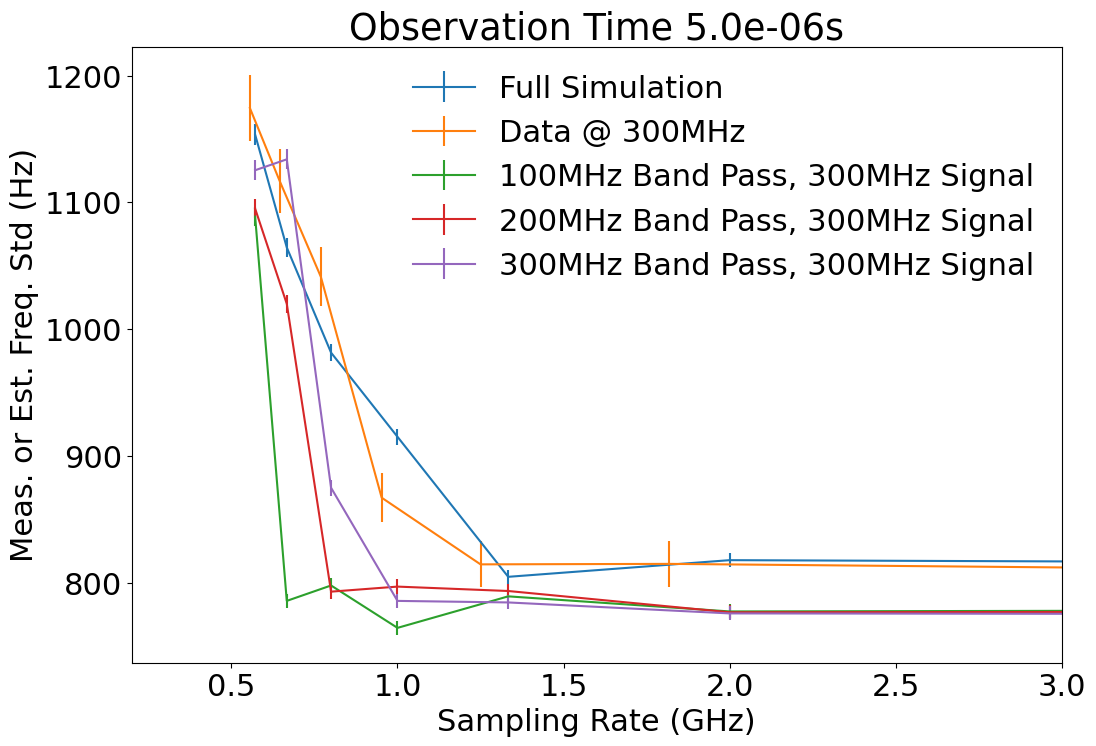

In [15]:
fig,ax = plt.subplots()
ax.errorbar(msaPerSecArray/1e9,bpFullFreqStd,yerr=bpFullFreqStd/np.sqrt(2*(10000-1)),label="Full Simulation")
measSps=np.array([19999.99973288,  3333.33328881,  1818.1817939,   1249.99998331, 952.38093966,   769.23075896,   645.16128171,   555.55554814])*1e6
measStd10000=np.array([0.02539105, 0.02542939, 0.02552737, 0.02547196, 0.02741887, 0.03304477, 0.03514254, 0.0354771 ])*1e6
measStd100000=np.array([0.00081308, 0.00081119, 0.00081479, 0.00081441, 0.00086702, 0.00104129, 0.00111695, 0.00117444])*1e6
ax.errorbar(measSps/1e9,measStd100000,yerr=measStd100000/np.sqrt(2*(1000-1)),label="Data @ 300MHz")
ax.errorbar(msaPerSecArray/1e9,bp100FreqStdT2,yerr=bp100FreqStdT2/np.sqrt(2*(10000-1)),label="100MHz Band Pass, 300MHz Signal")
ax.errorbar(msaPerSecArray/1e9,bp200FreqStd,yerr=bp200FreqStd/np.sqrt(2*(10000-1)),label="200MHz Band Pass, 300MHz Signal")
ax.errorbar(msaPerSecArray/1e9,bp300FreqStd,yerr=bp300FreqStd/np.sqrt(2*(10000-1)),label="300MHz Band Pass, 300MHz Signal")
ax.set_xlabel("Sampling Rate (GHz)")
ax.set_ylabel("Meas. or Est. Freq. Std (Hz)")
ax.legend()
#ax.set_yscale('log')
ax.set_xlim([0.2,3])
bigT=t[-1]-t[0]
ax.set_title('Observation Time {:.1e}s'.format(bigT))

In [16]:
def generateNoiseAndFit(tSine,vSine,gainNoise,numWaveforms,thisFreq,thisAmp):
    xf = pft.getFrequencyBins(len(tSine),tSine[1]-tSine[0])
    guessPhase=0
    guessOmega=thisFreq*2*math.pi
    guessAmp=thisAmp
    
    omegas=np.zeros(numWaveforms)
    freqs=np.zeros(numWaveforms)
    amps=np.zeros(numWaveforms)
    phases=np.zeros(numWaveforms)
    failCount=0

    print(xf.shape,gainNoise.shape,tSine.shape)
    #print("Guess",guessAmp,guessOmega,guessPhase)
    
    for i in range(numWaveforms):
        rfftVals=pft.generateThermalNoiseRFFT(xf,gainNoise,T=292,R=50)
        noiseVals=irfft(rfftVals)
     #   print(i,np.std(noiseVals),np.std(vSine))
        try:
            parameters, covariance = curve_fit(getSine, tSine, vSine+noiseVals,p0=[guessOmega,guessAmp,guessPhase])
            omegas[i]=parameters[0]
            freqs[i]=parameters[0]/(2*math.pi)
            amps[i]=parameters[1]
            phases[i]=parameters[2]
        except:
            print("Failure ",failCount," to fit",i)
            failCount=failCount+1
            if(failCount>10):
                raise Exception("Sorry I've given up after failing to fit",failCount)
    return omegas,freqs,amps,phases


def doSingleLoopForNetworkVaryingThings(thisT,gainNetwork,thisFreq,ampList,numWaves=1000):
    #Now some hideous code because I'm too lazy too chaneg the amplitude of the sine wave properly
    thisXf = pft.getFrequencyBins(len(thisT),thisT[1]-thisT[0])
    dt=thisT[1]-thisT[0]
    fs=1./dt
    N=len(thisT)
    idx= find_nearest_index(thisXf,thisFreq)
    thisGaindB=gainNetwork[idx]
    voltScale=np.power(10,thisGaindB/20)
    netFitAmpMeanList=[]
    netFitAmpStdList=[]
    netFitFreqMeanList=[]
    netFitFreqStdList=[]
    for rawAmp in ampList:
        thisAmp=rawAmp*voltScale
        print("Starting",thisFreq*2*math.pi,thisFreq,thisAmp,dt,fs,N)
                #Now we are going to reshape our array to have fewer entries
        grSine=getSine(thisT,thisFreq*2*math.pi,thisAmp,0)
        netOmega,netFreq,netAmp,netPhase=generateNoiseAndFit(thisT,grSine,gainNetwork,numWaves,thisFreq,thisAmp)
        netFitFreqStdList.append(np.std(netFreq))
        netFitFreqMeanList.append(np.mean(netFreq))
        netFitAmpMeanList.append(np.mean(netAmp))
        netFitAmpStdList.append(np.std(netAmp))
    return netFitAmpMeanList,netFitAmpStdList,netFitFreqMeanList,netFitFreqStdList

In [46]:
ampList = np.linspace(0.1,1,5)
scaledAmpList=ampList*np.power(10,-79/20)

msaList=[]
freqStdList=[]
numSampsList=[6000,6500,7000,8000,10000,20000]

for numSamples in numSampsList:
    t=np.linspace(0,1e-5,numSamples)
    xf = pft.getFrequencyBins(len(t),t[1]-t[0])
    gainBandPass100T2=connvertGainTodB(butterworthBandPass(xf,143e6,243e6,50,connvertdBToGain(79)))
    netFitAmpMeanList,netFitAmpStdList,netFitFreqMeanList,netFitFreqStdList=doSingleLoopForNetworkVaryingThings(t,gainBandPass100T2,200e6,scaledAmpList)
    msaList.append(1/(t[1]-t[0]))
    freqStdList.append(netFitFreqStdList)
    

/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_2971/1026499346.py:16: RuntimeWarning: divide by zero encountered in divide
  return 1./(1+np.power(fc/xf,2*order))
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_2971/1026499346.py:16: RuntimeWarning: overflow encountered in power
  return 1./(1+np.power(fc/xf,2*order))
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_2971/1026499346.py:23: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(gain)


Starting 1256637061.4359171 200000000.0 0.09999999965712657 1.6669444907484582e-09 599900000.0 6000
(3001,) (3001,) (6000,)
Starting 1256637061.4359171 200000000.0 0.32499999888566133 1.6669444907484582e-09 599900000.0 6000
(3001,) (3001,) (6000,)
Starting 1256637061.4359171 200000000.0 0.5499999981141962 1.6669444907484582e-09 599900000.0 6000
(3001,) (3001,) (6000,)
Starting 1256637061.4359171 200000000.0 0.7749999973427308 1.6669444907484582e-09 599900000.0 6000
(3001,) (3001,) (6000,)
Starting 1256637061.4359171 200000000.0 0.9999999965712656 1.6669444907484582e-09 599900000.0 6000
(3001,) (3001,) (6000,)
Starting 1256637061.4359171 200000000.0 0.09999999965668677 1.5386982612709648e-09 649900000.0 6500
(3251,) (3251,) (6500,)
Starting 1256637061.4359171 200000000.0 0.324999998884232 1.5386982612709648e-09 649900000.0 6500
(3251,) (3251,) (6500,)
Starting 1256637061.4359171 200000000.0 0.5499999981117772 1.5386982612709648e-09 649900000.0 6500
(3251,) (3251,) (6500,)
Starting 12566

Text(0.5, 1.0, 'Band 143-243MHz, 200MHz sine, Observation time 1e-5s')

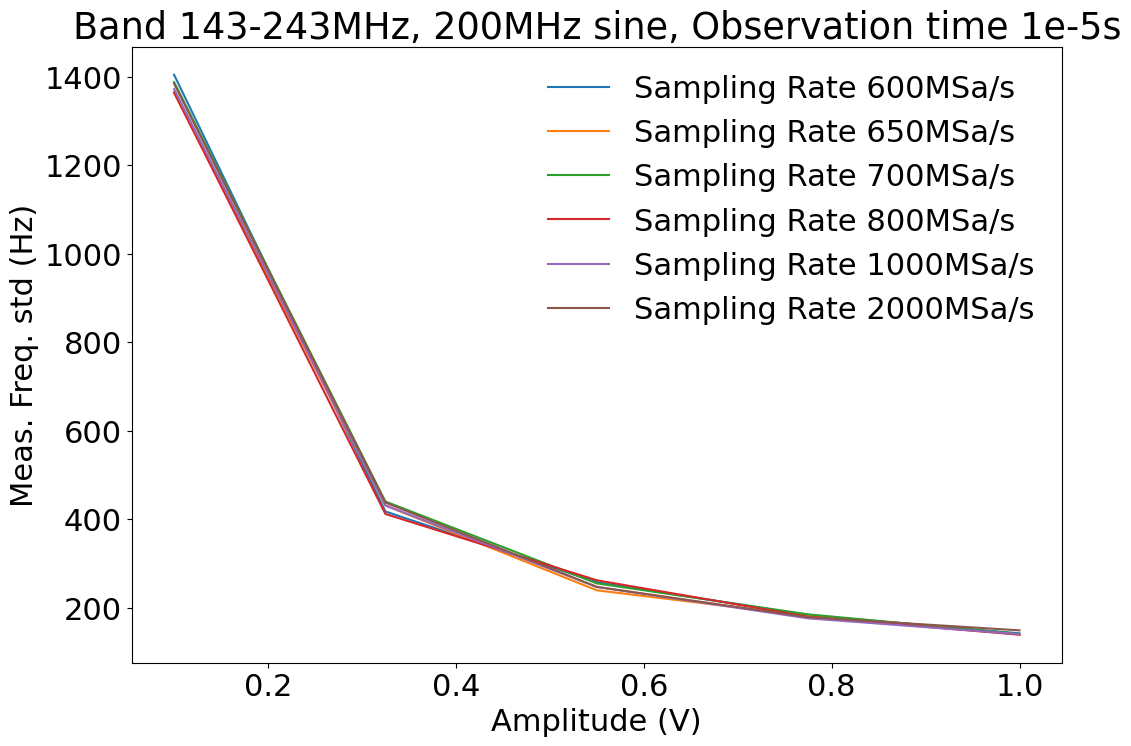

In [47]:
fig,ax = plt.subplots()
for ind in range(len(msaList)):
    ax.plot(ampList,freqStdList[ind],label='Sampling Rate {:3.0f}MSa/s'.format(msaList[ind]/1e6))
ax.set_xlabel("Amplitude (V)")
ax.set_ylabel("Meas. Freq. std (Hz)")
ax.legend()
ax.set_title("Band 143-243MHz, 200MHz sine, Observation time 1e-5s")